# Song lyrics exploration - Part 3: Word clouds

# Word cloud

Word clouds are a fun and oftentimes helpful technique for visualizing natural language data. They can show words scaled by any metric, although term frequency and term-frequency inverse-document-frequency (TF-IDF) are the most common metrics. For a multi-class or multi-label classification problem, word clouds can highlight the similarities and differences between separate classes by treating each class as its own document to compare with all others. The word clouds seen here were made with the `WordCloud` generator by [amueller](https://github.com/amueller/word_cloud), with pre-processing done via `gensim` and `nltk`.

In the case of heavy metal genre classification, term frequency alone is not too illuminating: the five genres we analyze here share a lot of common themes since they are all still metal. TF-IDF does much better at picking out the words that are unique to a genre. We see much of what we'd expect from a cursory understanding of each genre: black metal lyrics deal with topics like the occult, religion, and nature; death metal obsesses over the obscene and horrifying; heavy metal revolves around themes more familiar to rock and pop; power metal adopts the vocabulary of fantasies and histories; and thrash metal sings of violence, war, and... beer? The full corpus word cloud shows themes common to all heavy metal genres. Interestingly, metal artists sing about life much more than death.

### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from wordcloud import WordCloud

from nlp import get_stopwords, tokenize

C:\Users\philippe\Anaconda3\envs\metallyrics\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


### Data

In [2]:
df = pd.read_csv('songs-ml-1pct.csv')
genres = df.columns[1:]

### Combine songs from same genre into documents

Before combining all the songs into a corpus, [stop words](https://en.wikipedia.org/wiki/Stop_word) (common words that aren't critical to the meaning of a text, e.g. "the" and "of") are removed using a directory of stop words in various languages. I don't recall where I got my stop words but it's easy to find repositories of stop words like [Alir3z4/stop-words](https://github.com/Alir3z4/stop-words) and [6/stopwords-json](https://github.com/6/stopwords-json).

In [6]:
lyrics = df[df['black'] == 1].lyrics.apply(tokenize, **dict(english_only=True, stopwords=get_stopwords()))

In [29]:
tokenize_kwargs = dict(english_only=True, stopwords=get_stopwords())
corpus = []
for genre in genres:
    song_tokens = df[df[genre] == 1].lyrics.apply(lambda x: ' '.join(tokenize(x, **tokenize_kwargs)))
    genre_tokens = ' '.join(song_tokens).split()
    corpus.append(genre_tokens)

In [31]:
print("genre word counts:")
for i, genre in enumerate(genres):
    print(f"{genre:<15}{len(corpus[i])}")

genre word counts:
black          501697
death          1010419
deathcore      51089
doom           203060
folk           111708
gothic         132548
grindcore      92798
heavy          478204
metalcore      87681
power          634560
progressive    313213
symphonic      180234
thrash         534779


In [32]:
print("genre vocabulary sizes:")
for i, genre in enumerate(genres):
    print(f"{genre:<15}{len(set(corpus[i]))}")

genre vocabulary sizes:
black          18864
death          23565
deathcore      7314
doom           12306
folk           10430
gothic         10043
grindcore      11855
heavy          13996
metalcore      7691
power          14458
progressive    14826
symphonic      11702
thrash         16804


# Word cloud

In [33]:
def get_wordcloud_frequencies(texts, tfidf=False, min_df=0):
    print("creating dictionary")
    dictionary = Dictionary(texts)
    print("generating bag-of-words representation")
    vectors = [dictionary.doc2bow(text) for text in texts]
    if min_df > 0:
        print("filtering words")
        vectors = [[(id_, count) for id_, count in vector if count > min_df] for vector in vectors]
    if tfidf:
        print("generating TF-IDF model")
        tfidf = TfidfModel(vectors)
        vectors = [tfidf[vector] for vector in vectors]
    print("generating frequency dictionaries for WordCloud")
    out = []
    for vector in vectors:
        out.append({dictionary[id_]: count for id_, count in vector})
    return out

### Full corpus

creating dictionary
generating bag-of-words representation
generating frequency dictionaries for WordCloud


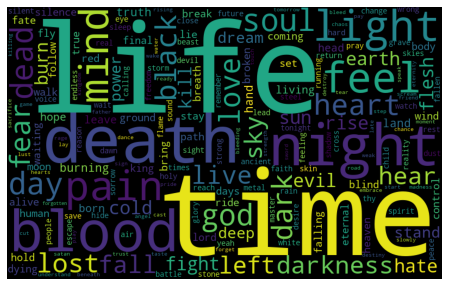

In [39]:
full_text = sum(corpus, [])
word_freqs = get_wordcloud_frequencies([full_text], tfidf=False, min_df=0)
word_cloud = WordCloud(width=800, height=500).fit_words(word_freqs[0])
plt.figure(figsize=(8, 5))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

### By genre

creating dictionary
generating bag-of-words representation
filtering words
generating TF-IDF model
generating frequency dictionaries for WordCloud
black


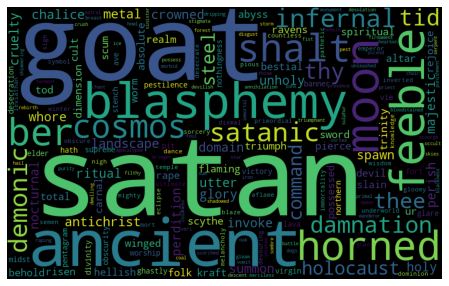

death


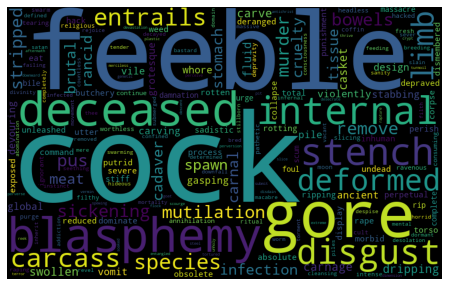

deathcore


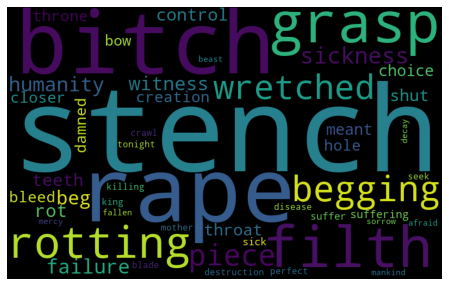

doom


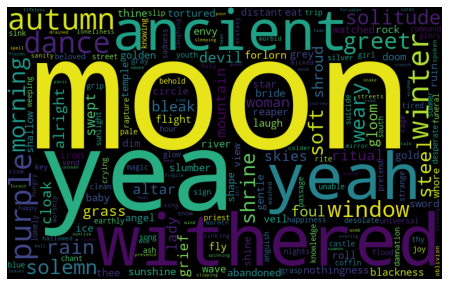

folk


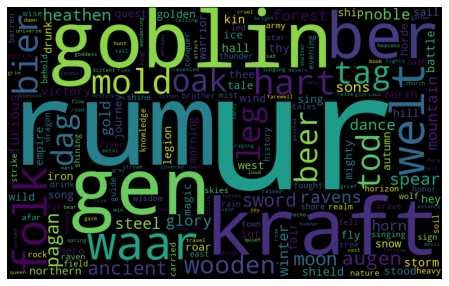

gothic


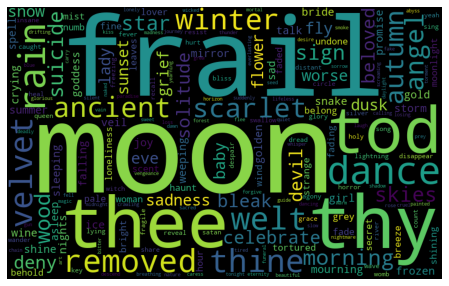

grindcore


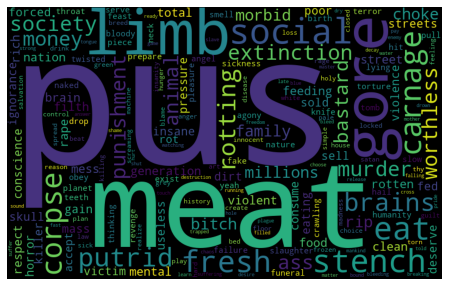

heavy


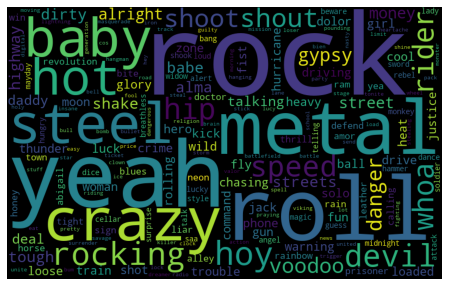

metalcore


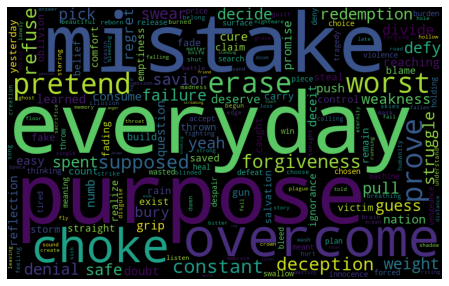

power


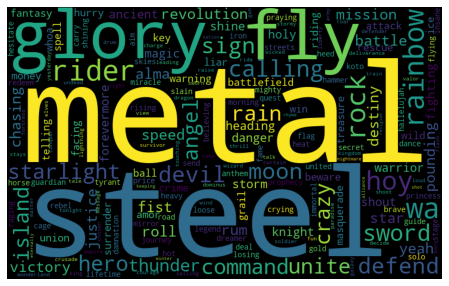

progressive


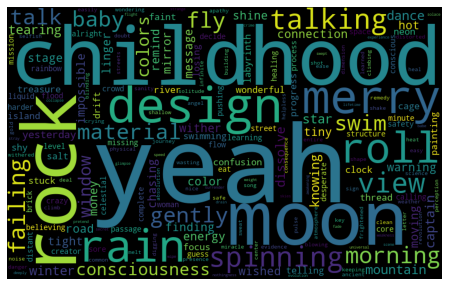

symphonic


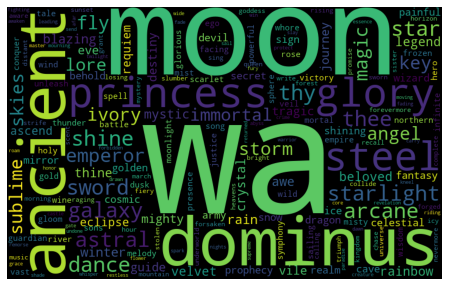

thrash


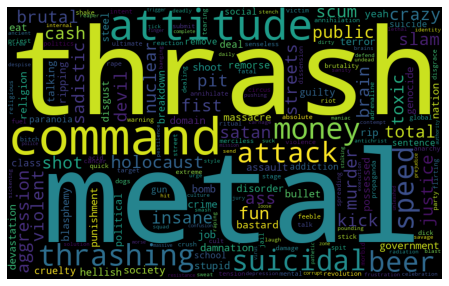

In [47]:
word_freqs = get_wordcloud_frequencies(corpus, tfidf=True, min_df=40)
for i, genre in enumerate(genres):
    print(genre)
    word_cloud = WordCloud(width=800, height=500).fit_words(word_freqs[i])
    plt.figure(figsize=(8, 5))
    plt.imshow(word_cloud)
    plt.axis('off')
    plt.show()